# Mass import statements

In [48]:
# ============================================================
# 0) Imports
# ============================================================

import pandas as pd
import numpy as np
import re
import json
import joblib
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [49]:
def split_benign():
    df = pd.read_csv("C:\\Users\\GameB\\Senior_Project2025\\vm_ddos_model\\vm_ddos_model\\Monday-WorkingHours.pcap_ISCX.csv")
    train = df.sample(frac=0.8, random_state=42)
    test  = df.drop(train.index)

    train.to_csv("benign_train_80.csv", index=False)
    test.to_csv("benign_test_20.csv", index=False)
    
if __name__ == "__main__":
    split_benign()

In [50]:
# ============================================================
# 1) Paths
# ============================================================

train_csv = "benign_train_80.csv"
val_csv   = "benign_test_20.csv"
malicious_csv = "C:\\Users\\GameB\\Senior_Project2025\\vm_ddos_model\\vm_ddos_model\\Wednesday-workingHours.pcap_ISCX.csv"


In [51]:
# ============================================================
# 2) Helper Functions
# ============================================================

def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [
        re.sub(r'[^0-9a-zA-Z_]+', '_', c).strip('_').lower()
        for c in df.columns
    ]
    return df


def load_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = clean_cols(df)
    df = df.replace([np.inf, -np.inf], np.nan)
    return df


def remove_non_dos_attacks(path: str = malicious_csv) -> pd.DataFrame:
    df = load_csv(path)
    allowed_labels = [
        "BENIGN",
        "DoS Hulk",
        "DoS GoldenEye",
        "DoS Slowloris",
        "DoS Slowhttptest"
    ]
    df = df[df["label"].isin(allowed_labels)]
    print("Filtered malicious label counts:")
    print(df["label"].value_counts())
    return df


In [52]:
# ============================================================
# 3) Feature List (UNCHANGED)
# ============================================================

features = [
    "flow_duration",
    "total_fwd_packets",
    "total_backward_packets",
    "flow_bytes_s",
    "flow_packets_s",
    "fwd_packet_length_mean",
    "bwd_packet_length_mean",
    "flow_iat_mean",
    "active_mean",
    "idle_mean",
    "syn_flag_count",
    "bwd_packets_s",
    "total_length_of_fwd_packets",
    "total_length_of_bwd_packets",
    "flow_iat_std",
    "flow_iat_min",
    "fwd_iat_std",
    "bwd_iat_std",
    "packet_length_std",
    "packet_length_variance",
    "ack_flag_count",
    "psh_flag_count",
    "rst_flag_count",
    "subflow_fwd_packets",
    "subflow_bwd_packets"
]


In [53]:
# ============================================================
# 4) Load Data
# ============================================================

X_train = load_csv(train_csv)
X_val   = load_csv(val_csv)


In [54]:
# ============================================================
# 5) Flow-Window Temporal Aggregation
# ============================================================

def build_flow_windows(df, features, window_size=200, stride=50):
    windows = []

    for start in range(0, len(df) - window_size + 1, stride):
        w = df.iloc[start:start + window_size]

        agg = {}
        for f in features:
            agg[f + "_mean"] = w[f].mean()
            agg[f + "_std"]  = w[f].std()
            agg[f + "_min"]  = w[f].min()
            agg[f + "_max"]  = w[f].max()

        windows.append(agg)

    return pd.DataFrame(windows).fillna(0)


In [55]:
# ============================================================
# 6) Build Windowed Training / Validation Sets
# ============================================================

X_train_win = build_flow_windows(X_train[features], features)
X_val_win   = build_flow_windows(X_val[features], features)


In [56]:
# ============================================================
# 7) Build Isolation Forest Pipeline (WINDOWED)
# ============================================================

window_features = X_train_win.columns.tolist()

pre = ColumnTransformer([
    ("num", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", RobustScaler())
    ]), window_features)
])

iso = IsolationForest(
    n_estimators=100,
    contamination="auto",
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline([
    ("pre", pre),
    ("clf", iso)
])

pipe.fit(X_train_win)


,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [57]:
# ============================================================
# 8) Threshold Calibration (Benign Windows Only)
# ============================================================

val_scores = pipe.named_steps["clf"].decision_function(
    pipe.named_steps["pre"].transform(X_val_win)
)

target_fpr = 0.09
threshold = np.quantile(val_scores, target_fpr)

emp_fpr = (val_scores < threshold).mean()

print(f"Threshold: {threshold:.6f}")
print(f"Empirical benign FPR: {emp_fpr:.4%}")


Threshold: -0.079199
Empirical benign FPR: 9.0265%


Filtered malicious label counts:
label
BENIGN              440031
DoS Hulk            231073
DoS GoldenEye        10293
DoS Slowhttptest      5499
Name: count, dtype: int64
TP (DoS windows detected): 6289
FP (Benign windows flagged): 457
FN (Missed DoS windows): 2421
TN (Correct benign windows): 4567
Malicious precision: 0.9323
Malicious recall:    0.7220
Benign specificity:  0.9090
Accuracy:            0.7904


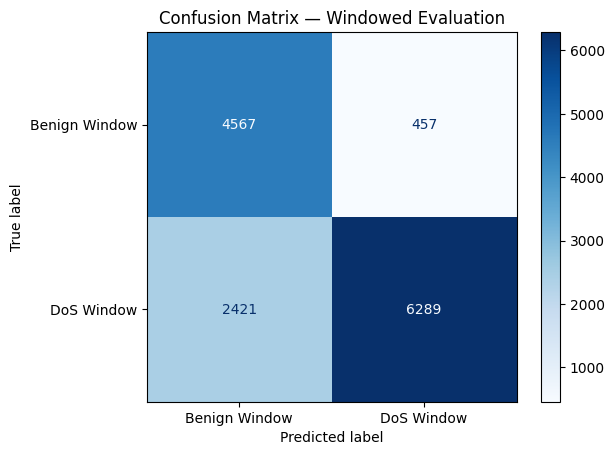

In [58]:
# ============================================================
# 9) Malicious Evaluation (Windowed)
# ============================================================

malicious_filtered = remove_non_dos_attacks()

X_mal_win = build_flow_windows(
    malicious_filtered[features],
    features
)

# Window labels: 1 if ANY flow in window is malicious
y_true = []

window_size = 200
stride = 50

labels = malicious_filtered["label"].apply(
    lambda x: 0 if str(x).upper() == "BENIGN" else 1
).values

for start in range(0, len(labels) - window_size + 1, stride):
    y_true.append(int(labels[start:start + window_size].any()))

y_true = np.array(y_true)

scores = pipe.named_steps["clf"].decision_function(
    pipe.named_steps["pre"].transform(X_mal_win)
)

y_pred = (scores < threshold).astype(int)

cm = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = cm.ravel()

malicious_precision = TP / (TP + FP)
malicious_recall    = TP / (TP + FN)
benign_specificity  = TN / (TN + FP)
accuracy            = (TP + TN) / (TP + TN + FP + FN)

print("TP (DoS windows detected):", TP)
print("FP (Benign windows flagged):", FP)
print("FN (Missed DoS windows):", FN)
print("TN (Correct benign windows):", TN)

print(f"Malicious precision: {malicious_precision:.4f}")
print(f"Malicious recall:    {malicious_recall:.4f}")
print(f"Benign specificity:  {benign_specificity:.4f}")
print(f"Accuracy:            {accuracy:.4f}")

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Benign Window", "DoS Window"]
)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix — Windowed Evaluation")
plt.show()


In [59]:
# ============================================================
# 10) Persistence-Based Alerting
# ============================================================

def persistent_alert(preds, k=3):
    return np.convolve(preds, np.ones(k), mode="valid") >= k

alerts = persistent_alert(y_pred, k=3)

print(f"Triggered persistent alerts: {alerts.sum()}")


Triggered persistent alerts: 5412


In [60]:
# ============================================================
# 11) Save Model + Threshold
# ============================================================

joblib.dump(pipe, "iso_forest_windowed_model.joblib")

with open("iso_threshold.json", "w") as f:
    json.dump({"threshold": float(threshold)}, f)
